In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context('poster')
sns.set_color_codes()

In [3]:
import clumpy
from clumpy import datasets

/home/joshua/workspace/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/joshua/workspace/scikit-learn/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


### 10k Diabetes Processing
- Numerics: Center and Scale
- Categoricals: Remove categoricals with < 2 levels, Add a level for missing values, One-Hot Encode

In [4]:
from clumpy.datasets import fetch_10kdiabetes
diabetes = fetch_10kdiabetes()

In [5]:
numeric_indices = range(diabetes.as_numeric().shape[1])
categorical_indices = range(diabetes.as_numeric().shape[1], diabetes.as_cleaned().shape[1])
X = np.hstack((diabetes.as_numeric().values, diabetes.as_ordinal().values))
dist_func = clumpy.metrics.GowerDistance(
    numeric_indices=numeric_indices, categorical_indices=categorical_indices, n_jobs=-1, gamma=1.0)
dis = dist_func(X)


/home/joshua/.virtualenvs/plot/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:200: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))
/home/joshua/.virtualenvs/plot/local/lib/python2.7/site-packages/pandas/core/frame.py:2762: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


### Fit TSNE on pre-computed dissimilarity matrix

In [6]:
from sklearn.manifold import TSNE

#scaled_pca = pca - np.mean(pca, axis=0)
#scaled_pca /= np.max(scaled_pca, axis=0)
tsne = TSNE(n_components=2, random_state=1234, verbose=True, init='random', metric='precomputed')
embedding = tsne.fit_transform(dis)
embedding -= np.mean(embedding, axis=0)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 10000
[t-SNE] Computed conditional probabilities for sample 2000 / 10000
[t-SNE] Computed conditional probabilities for sample 3000 / 10000
[t-SNE] Computed conditional probabilities for sample 4000 / 10000
[t-SNE] Computed conditional probabilities for sample 5000 / 10000
[t-SNE] Computed conditional probabilities for sample 6000 / 10000
[t-SNE] Computed conditional probabilities for sample 7000 / 10000
[t-SNE] Computed conditional probabilities for sample 8000 / 10000
[t-SNE] Computed conditional probabilities for sample 9000 / 10000
[t-SNE] Computed conditional probabilities for sample 10000 / 10000
[t-SNE] Mean sigma: 0.233887
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.460807
[t-SNE] Error after 325 iterations: 1.460807


### Cluster using HDBSCAN

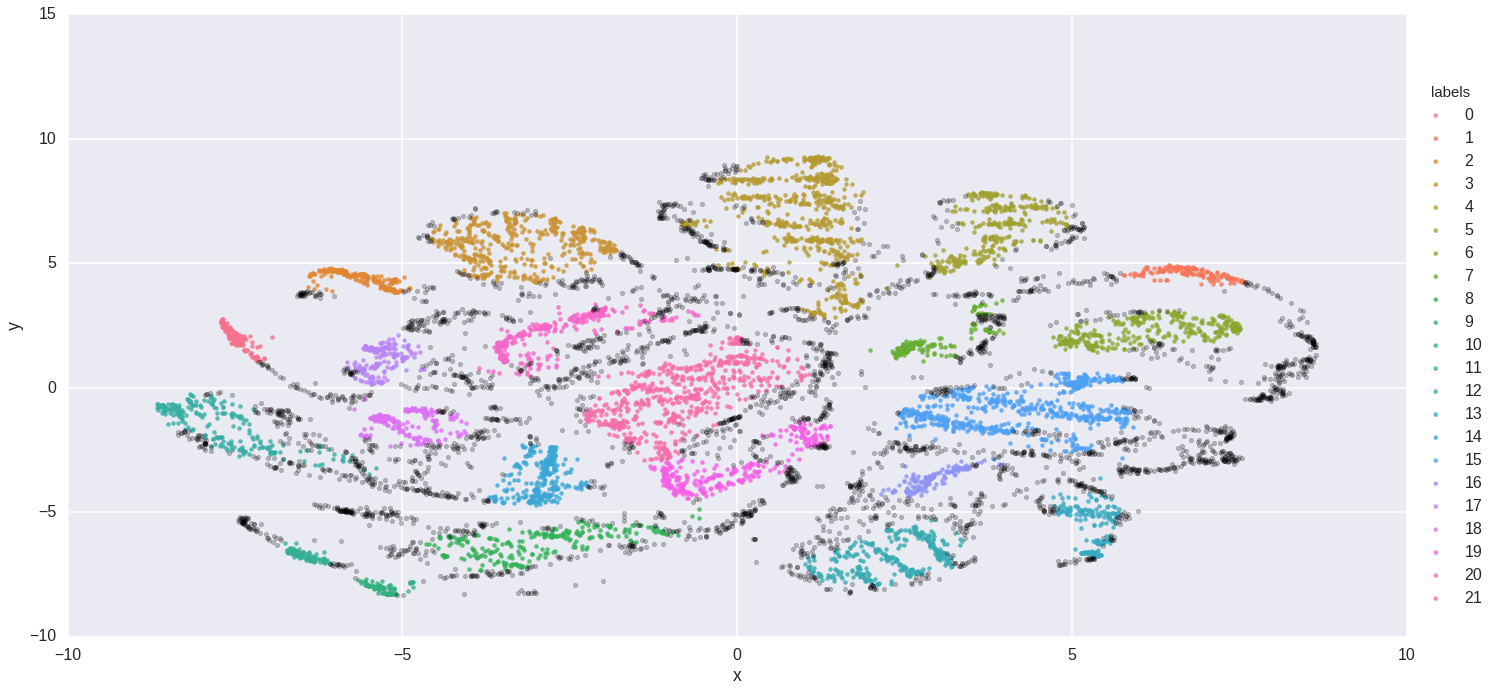

In [9]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=int(diabetes.as_raw().shape[0] * .01)).fit(embedding)
clumpy.plots.plot_clusters(embedding, clusterer.labels_)

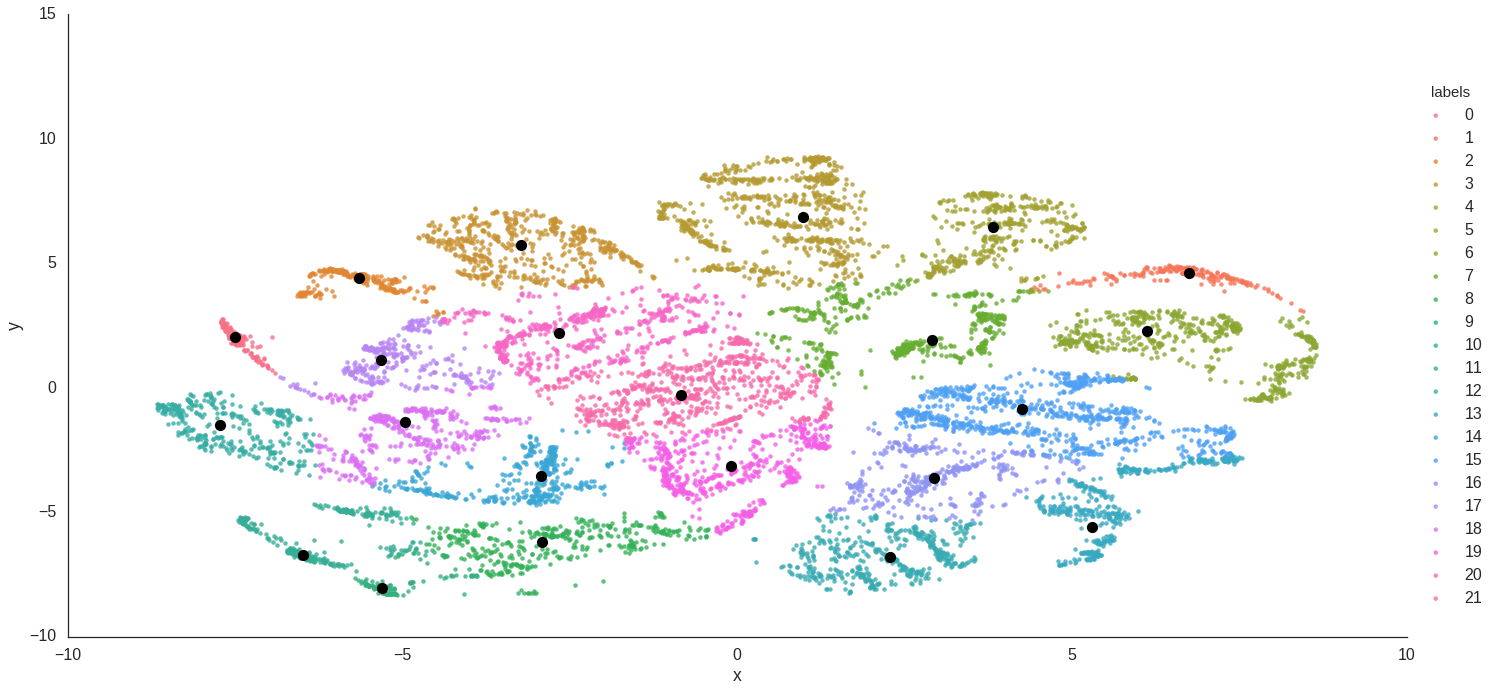

In [138]:
from clumpy.base import convert_to_kmeans

kmeans = convert_to_kmeans(embedding, clusterer)
clumpy.plots.plot_clusters(embedding, kmeans.labels_, kmeans.cluster_centers_)

In [69]:
from clumpy.auto_kmeans import auto_kmeans
kmeans = auto_kmeans(embedding)

In [139]:
from clumpy import importance
data = pd.concat([diabetes.as_numeric(), 
                  diabetes.as_ordinal()], axis=1)

importance.deviation_importance(data.values, kmeans.labels_, feature_names=data.columns.tolist())

{0: ['time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient'],
 1: ['time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications'],
 2: ['time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient',
  'number_diagnoses',
  'race'],
 3: ['time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency'],
 4: ['time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatient',
  'number_emergency',
  'number_inpatient',
  'number_diagnoses',
  'race',
  'gender',
  'age',
  'weight',
  'admission_type_id',
  'discharge_disposition_id',
  'admission_source_id',
  'payer_code'],
 5: ['time_in_hospital',
  'num_lab_procedures',
  'num_procedures',
  'num_medications',
  'number_outpatie

In [53]:
from clumpy.rules import tree_descriptions

data = pd.concat([diabetes.as_numeric(), 
                  diabetes.as_ordinal()], axis=1)
rules = tree_descriptions(data.values, 
                  kmeans.labels_, 
                  feature_names=data.columns.tolist(),
                  max_depth=20,
                  n_features=10)

0.5 < num_procedures <= 2.5 AND
3.5 < number_diagnoses <= 6.5 AND
time_in_hospital <= 8.5 

num_medications <= 72.0 AND
0.5 < num_procedures <= 1.5 AND
5.5 < number_diagnoses <= 6.5 AND
10.5 < time_in_hospital <= 11.5 

num_lab_procedures > 3.5 AND
num_procedures <= 0.5 AND
6.5 < number_diagnoses <= 7.5 AND
6.5 < time_in_hospital <= 7.5 



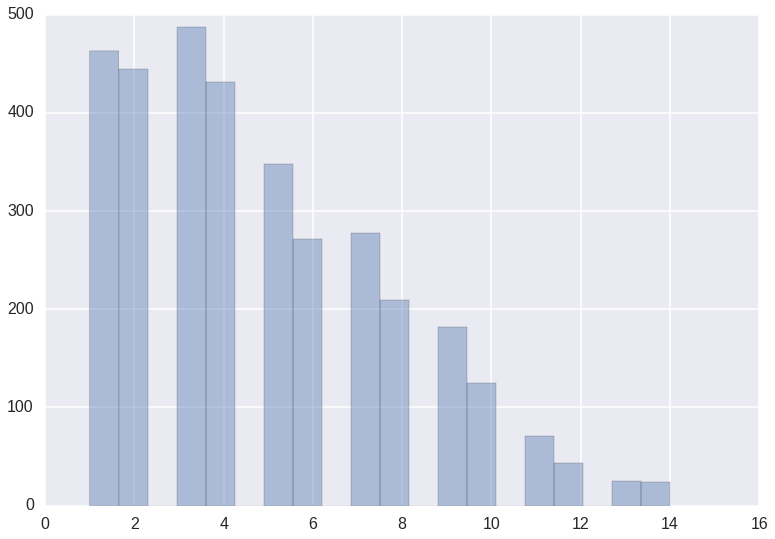

In [60]:
for rule in rules[:6]:
    print(rule)
    print
sns.distplot(data.values[kmeans.labels_ == 1][:,
#sns.distplot(data.values[:,
np.where(data.columns=='time_in_hospital')], kde=False )


In [336]:
from clumpy.summary import cluster_summary
summary = cluster_summary(diabetes.as_cleaned(), kmeans, bin_numeric=True)
summary

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide.metformin,glipizide.metformin,change,diabetesMed
cluster,,,,,,,,,,,,,,,,,,,,,
0,7,10,4,9,5,1,2,6,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
1,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
2,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
3,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
4,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
5,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
6,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
7,6,10,4,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
8,7,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes


### Feature Importance

In [45]:
from clumpy.cluster_rules import ova_forest_importance

def cluster_name(summary, features):
    names = []
    for cluster_index in summary.index:       
        d = summary.loc[cluster_index]
        name =''
        fmt = '{var}={value}'
        for var in features[cluster_index]:
            name += fmt.format(var=var, value=d.loc[var])
            name += '; '
        names.append(name)
    return names

data = pd.concat([diabetes.as_numeric(), diabetes.as_ordinal()], axis=1)
features = ova_forest_importance(data, kmeans.labels_, columns=diabetes.as_cleaned().columns, top_k=5)
cluster_names = cluster_name(summary, features)

In [46]:
summary.index = cluster_names
summary

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race,gender,...,pioglitazone,rosiglitazone,acarbose,miglitol,tolazamide,insulin,glyburide.metformin,glipizide.metformin,change,diabetesMed
race=Caucasian; age=[80-90); time_in_hospital=7; gender=Female; weight=?;,7,10,4,9,5,1,2,6,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
time_in_hospital=6; race=Caucasian; gender=Female; age=[70-80); diag_3=250.0;,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
time_in_hospital=6; age=[70-80); race=Caucasian; weight=?; number_diagnoses=7;,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
age=[70-80); time_in_hospital=6; race=Caucasian; diag_2=428.0; diag_3=428.0;,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
time_in_hospital=6; age=[70-80); number_emergency=1; race=Caucasian; gender=Female;,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
time_in_hospital=6; age=[70-80); gender=Female; diag_3=250.0; weight=?;,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
age=[70-80); time_in_hospital=6; race=Caucasian; gender=Female; diag_2=276.0;,6,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
time_in_hospital=6; age=[70-80); gender=Female; race=Caucasian; weight=?;,6,10,4,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
time_in_hospital=7; gender=Female; age=[60-70); diag_3=250.0; diag_2=250.0;,7,10,5,9,4,1,2,7,Caucasian,Female,...,No,No,No,No,No,No,No,No,No,Yes
time_in_hospital=6; number_diagnoses=7; gender=Female; diag_2=250.0; num_lab_procedures=10;,6,10,4,9,5,1,2,7,Caucasian,Female,...,No,No,No,No,No,Steady,No,No,No,Yes


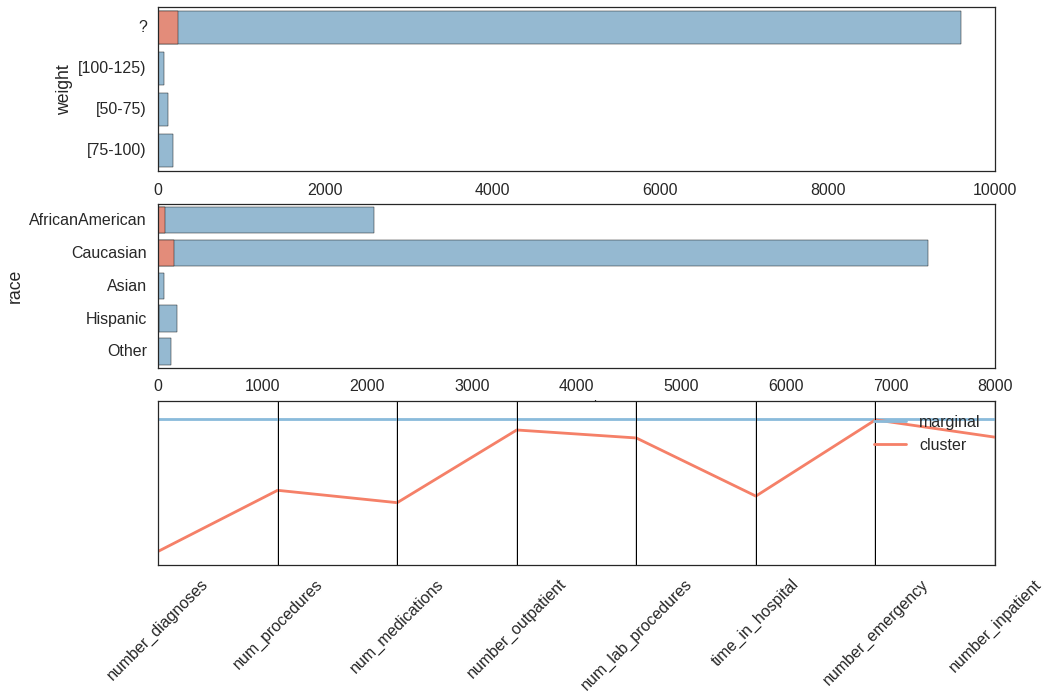

In [142]:
from clumpy.plots import quant_plot
#quant_plot('power (hp)', kmeans.labels_, 0, imputed_data)
plot_cluster_statistics(
    cluster_labels=kmeans.labels_, 
    cluster_id=2, 
    data=diabetes.as_cleaned(), scale=True,
    quant_var=diabetes.as_numeric().columns.tolist(),
    qual_var=['weight', 'race'],
    figsize=(15,10))